# Assignment-2 #

## Salary prediction from kaggle survey 2018 ##

Following is the script for the analysis.

#### Importing required libraries ####

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import learning_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

Reading the 'kaggle_salary.csv' file from the local directory. Since the file consists of different data types (float, int and string) the command throws a warning, which is ignored.

In [2]:
df = pd.read_csv("kaggle_salary.csv")

/home/jupyterlab/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (1,3,9,11,13,22,24,25,26,27,28,29,45,57,65,84,86,88,108,110,124,126,151,195,209,224,250,263,265,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,305,307,323,326,327,330,342,372,385,386,394,395) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The length of columns shown, to get an idea about the number of features.

In [3]:
len(df.columns)

397

### Part 1: Data cleaning ###

A heatmap of the entire dataset was plotted to check for null values (shown in red) in the whole dataset.

Text(0.5, 50.09375, 'Features')

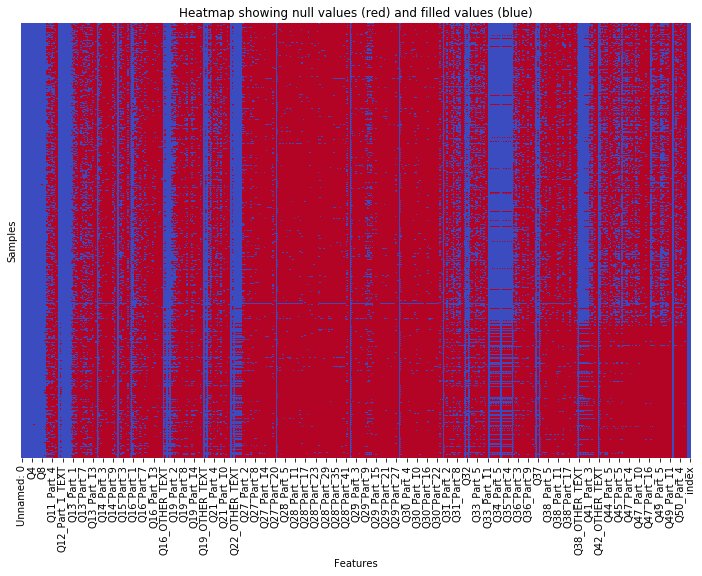

In [4]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(df.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)
ax.set_title('Heatmap showing null values (red) and filled values (blue)')
ax.set_ylabel('Samples')
ax.set_xlabel('Features')

For initial simplification, columns with null values greater than 95%, in 70% of the rows, were dropped. The heuristic behind this step is that when the data is split into train and test samples using a 70-30 split, these columns would contribute to less than 5% of the samples and hence would not affect the model fitting significantly.

Following piece of code stores the column names to keep and to drop as separate lists: to_drop and to_keep.

In [5]:
to_drop = []
to_keep = []
for column in df.columns:
    df_col = df[column]
    df_col_drop = df_col[df_col.notna()]
    if len(df_col_drop)/(0.7*len(df_col)) < 0.05:
        to_drop.append(column)
    else:
        to_keep.append(column)

The dataframe was hence stripped of those features/columns.

In [6]:
df = df[to_keep]

The question/column corresponding to the salaries, which is our ultimate target variable, was separated out into a new pandas series called 'salaries'. the column was thereafter dropped from main dataframe.

In [7]:
salaries = df['Q9']

In [8]:
df = df.drop('Q9', axis=1)

A list of columns was created, called 'cols' for future reference.

In [9]:
cols = df.columns

In [10]:
cols

Index(['Unnamed: 0', 'Time from Start to Finish (seconds)', 'Q1',
       'Q1_OTHER_TEXT', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q6_OTHER_TEXT',
       ...
       'Q49_OTHER_TEXT', 'Q50_Part_1', 'Q50_Part_2', 'Q50_Part_3',
       'Q50_Part_4', 'Q50_Part_5', 'Q50_Part_6', 'Q50_Part_7',
       'Q50_OTHER_TEXT', 'index'],
      dtype='object', length=270)

A new dictionary called col_dict was created which has the question numbers (e.g. 'Q12') as keys and a list of all the parts of the respective question (e.g. 'Q12_MULTPLE_CHOICE', etc.) as its values. This was done to make it convenient to refer to all the sub-parts of the questions at the same time.

In [11]:
col_dict = {'Time from Start to Finish (seconds)': ['Time from Start to Finish (seconds)']}
for num in range(1,51):
    ques = 'Q' + str(num)
    col_dict[ques] = []
    for title in cols:
        if title.split('_')[0] == ques:
            col_dict[ques].append(title)          

Another dictionary called 'ques_dict' was created to store the actual text of each question mentioned in the first row of the dataframe. The first row is thereafter dropped from the dataframe as it does not contain any real data.

In [12]:
ques_dict = dict(zip(df.columns,df.iloc[0]))

The dictionary was made visible for back-and-forth manual reference.

In [13]:
ques_dict

{'Unnamed: 0': 0,
 'Time from Start to Finish (seconds)': 'Duration (in seconds)',
 'Q1': 'What is your gender? - Selected Choice',
 'Q1_OTHER_TEXT': 'What is your gender? - Prefer to self-describe - Text',
 'Q2': 'What is your age (# years)?',
 'Q3': 'In which country do you currently reside?',
 'Q4': 'What is the highest level of formal education that you have attained or plan to attain within the next 2 years?',
 'Q5': 'Which best describes your undergraduate major? - Selected Choice',
 'Q6': 'Select the title most similar to your current role (or most recent title if retired): - Selected Choice',
 'Q6_OTHER_TEXT': 'Select the title most similar to your current role (or most recent title if retired): - Other - Text',
 'Q7': 'In what industry is your current employer/contract (or your most recent employer if retired)? - Selected Choice',
 'Q7_OTHER_TEXT': 'In what industry is your current employer/contract (or your most recent employer if retired)? - Other - Text',
 'Q8': 'How many y

Following step gets rid of the first row in the dataframe, as explained in the previous step.

In [14]:
df = df[df['Q2']!= "What is your age (# years)?"]

There is an unnecessary column in the dataframe (probably the index column from a previous instance of the dataframe) which was dropped in the following step, as it is not needed for regression modelling.

In [15]:
df = df.drop('Unnamed: 0', axis=1)

On closer inspection of the actual content of columns for question 1, it was founf that the 'OTHER_TEXT' column contained integer values corresponding to the type of entry in the main column, i.e. -1 for Male/Female and a cummulative count value for 'Prefer to self-describe'. Since it won't be of use as a feature in the final modelling, it was dropped.

In fact, for most questions, the 'OTHER_TEXT' column contains similar information respectively. Hence, those columns would be dropped in future as and when they appear in the analysis sequence.

In [16]:
df = df.drop('Q1_OTHER_TEXT', axis=1)

The column label was simultaneously removed from the comprehensive columns dictionary as well to avoid key errors.

In [17]:
col_dict['Q1'].remove('Q1_OTHER_TEXT')

Removing 'OTHER_TEXT' column for Q6 and removing the label from dictionary as well.

In [18]:
df = df.drop('Q6_OTHER_TEXT', axis=1)

In [19]:
col_dict['Q6'].remove('Q6_OTHER_TEXT')

Some very trivial exploratory steps for checking the usefulness of some functions that can be used to get a sense of the data.

In [20]:
df.Q11_Part_1.value_counts()

Analyze and understand data to influence product or business decisions    7463
Name: Q11_Part_1, dtype: int64

In [21]:
ques_list = col_dict.keys()

In [22]:
df_ques = df[col_dict['Q11']]

In [23]:
len(df_ques.iloc[5].dropna())

3

Checking whether Q2 column has any null values or not.

In [24]:
df_ques = df[col_dict['Q2']]

In [25]:
len(df_ques),len(df_ques.dropna())

(15429, 15429)

An attempt was made for all the questions having no sub-parts (i.e. only 1 column for each question), to convert their data types into float to see how many categorical variables are present.

In [26]:
for col in ques_list:
    df_ques = df[col_dict[col]]
    if len(df_ques.columns) == 1:
        if len(df_ques) == len(df_ques.dropna()):
            try:
                df[col_dict[col]] = df[col_dict[col]].astype(float)
            except:
                continue

Checking the completeness of the "Time...to Finish (seconds)" column and coverting it to float.

In [27]:
len(df[['Time from Start to Finish (seconds)']]), len(df[['Time from Start to Finish (seconds)']].dropna())

(15429, 15429)

In [28]:
df['Time from Start to Finish (seconds)'] = df['Time from Start to Finish (seconds)'].astype(float)

Making a new list: 'single_part' consisting of all questions having single parts (individual columns)

In [29]:
single_part = []
for col in ques_list:
    if len(col_dict[col]) == 1:
        single_part.append(col_dict[col][0])

Outputting the data types of all those single column questions.

In [30]:
df[single_part].dtypes

Time from Start to Finish (seconds)    float64
Q1                                      object
Q2                                      object
Q3                                      object
Q4                                      object
Q5                                      object
Q6                                      object
Q8                                      object
Q10                                     object
Q23                                     object
Q24                                     object
Q25                                     object
Q26                                     object
Q40                                     object
Q43                                     object
Q46                                     object
Q48                                     object
dtype: object

Making a new dataframe containing only the single part columns for some temporary data collection on those columns.

In [31]:
df_single = df[single_part]

In [32]:
single_part

['Time from Start to Finish (seconds)',
 'Q1',
 'Q2',
 'Q3',
 'Q4',
 'Q5',
 'Q6',
 'Q8',
 'Q10',
 'Q23',
 'Q24',
 'Q25',
 'Q26',
 'Q40',
 'Q43',
 'Q46',
 'Q48']

Creating new dictionary 'missing_col_single_dict' for recording the questions with missing data along with the percentage of missing data.

In [33]:
missing_col_single_dict={}
for col in df_single.columns:
    if len(df_single[df_single[col].notna()]) < len(df_single[col]):
        missing_col_single_dict[col] = (len(df_single[col])-len(df_single[df_single[col].notna()]))*100/len(df_single[col])

In [34]:
print(missing_col_single_dict)

{'Q5': 0.8749756951195801, 'Q8': 0.4925789098450969, 'Q10': 1.892540022036425, 'Q23': 12.755201244409877, 'Q24': 12.884827273316482, 'Q25': 13.053341110895067, 'Q26': 13.11167282390304, 'Q40': 24.389137338777626, 'Q43': 36.13325555771599, 'Q46': 35.19994814958844, 'Q48': 35.09624732646316}


Above is the dictionary containing the single part columns with missing data data along with percentage of values missing. Q 5, 8 and 10 have less than 5% missing values. Therefore, these would be replaced by one of the appropriate categories in the respective columns.

To figure out the appropriate categories, we need to visualize the distribution of the respective categories in each column.

In [35]:
df_single.Q5.value_counts().index

Index(['Computer science (software engineering, etc.)',
       'Engineering (non-computer focused)', 'Mathematics or statistics',
       'A business discipline (accounting, economics, finance, etc.)',
       'Physics or astronomy',
       'Information technology, networking, or system administration',
       'Medical or life sciences (biology, chemistry, medicine, etc.)',
       'Other', 'Social sciences (anthropology, psychology, sociology, etc.)',
       'Humanities (history, literature, philosophy, etc.)',
       'Environmental science or geology', 'I never declared a major',
       'Fine arts or performing arts'],
      dtype='object')

Following code gives 3 bar plots for the value counts for each of the questions 5, 8 and 10.

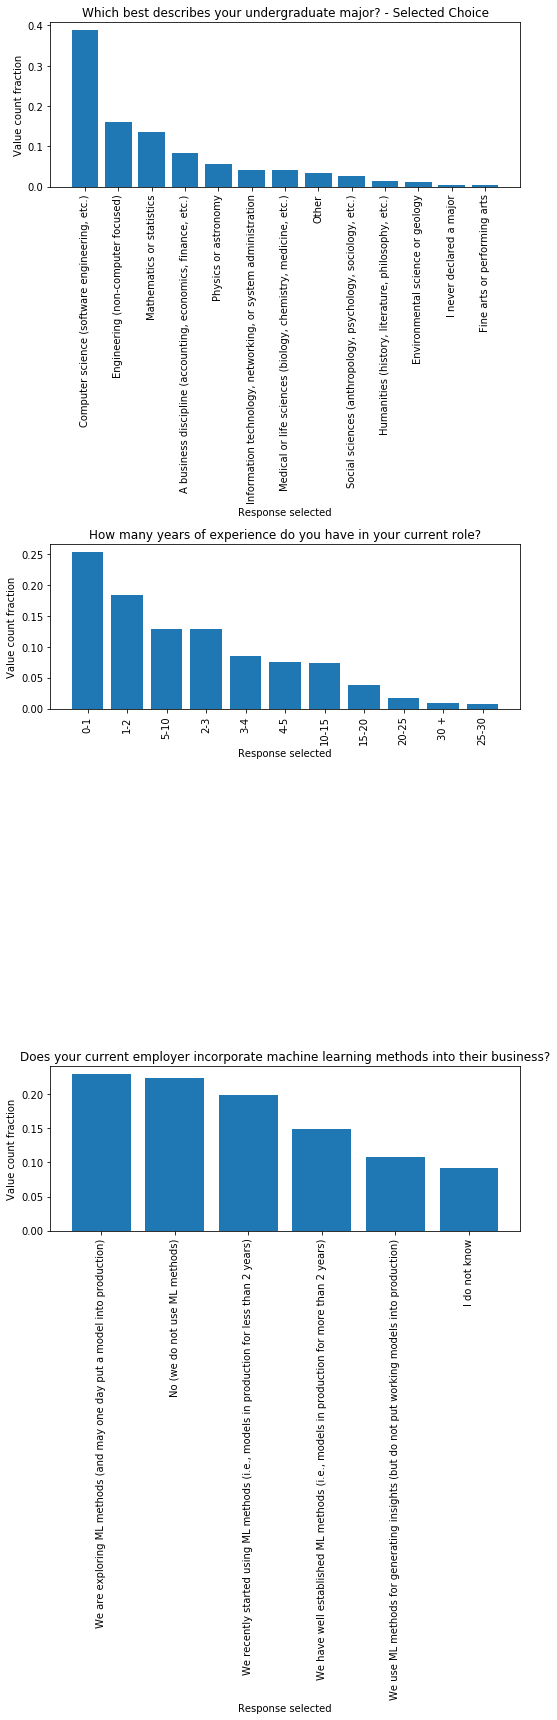

In [36]:
fig, axes = plt.subplots(3,1,figsize=(8,24))

axes[0].bar(df_single.Q5.value_counts().index, np.array(df_single.Q5.value_counts())/sum(df_single.Q5.value_counts()))
axes[0].set_xticks(df_single.Q5.value_counts().index)
axes[0].set_xlabel('Response selected')
axes[0].tick_params('x',labelrotation=90)
axes[0].set_title(ques_dict['Q5'])
axes[0].set_ylabel('Value count fraction')

axes[1].bar(df_single.Q8.value_counts().index, np.array(df_single.Q8.value_counts())/sum(df_single.Q8.value_counts()))
axes[1].set_xticks(df_single.Q8.value_counts().index)
axes[1].tick_params('x',labelrotation=90)
axes[1].set_xlabel('Response selected')
axes[1].set_title(ques_dict['Q8'])
axes[1].set_ylabel('Value count fraction')

axes[2].bar(df_single.Q10.value_counts().index, np.array(df_single.Q10.value_counts())/sum(df_single.Q10.value_counts()))
axes[2].set_xticks(df_single.Q10.value_counts().index)
axes[2].tick_params('x',labelrotation=90)
axes[2].set_xlabel('Response selected')
axes[2].set_title(ques_dict['Q10'])
axes[2].set_ylabel('Value count fraction')
plt.tight_layout()

Based on the above plots, Q5 would be filled by the values contributing to more than 50% of the share (i.e. 'Computer science...' and 'Engineering...') as a random sample from the column containing only these 2 labels.

Missing values in Q8 would be populated using a random sample from all of the labels as there is no clear majority share for any years of experience groups.

Missing values in Q10 would be populated using 'I do not know labels' as that seems the most appropriate response in this case.

In [37]:
print(sum(df.Q5.value_counts()))

15294


Initially 15294 sample values were filled for Q5.

Following code fills up the missing values with a random choice from 'Computer science...' and 'Engineering...'

In [38]:
df['Q5'].fillna(np.random.choice(df[(df['Q5']=='Computer science (software engineering, etc.)') | (df['Q5']=='Engineering (non-computer focused)')]["Q5"]), inplace =True)

Confirming that all missing values are filled.

In [39]:
print(sum(df.Q5.value_counts()))

15429


Filling missing values for Q8.

In [40]:
print(df.Q8.value_counts())
print(sum(df.Q8.value_counts()))

0-1      3879
1-2      2826
5-10     1973
2-3      1965
3-4      1308
4-5      1145
10-15    1123
15-20     595
20-25     271
30 +      144
25-30     124
Name: Q8, dtype: int64
15353


In [41]:
df['Q8'].fillna(np.random.choice(df[df['Q8'].notna()]["Q8"]), inplace =True)

In [42]:
print(df.Q8.value_counts())
print(sum(df.Q8.value_counts()))

0-1      3955
1-2      2826
5-10     1973
2-3      1965
3-4      1308
4-5      1145
10-15    1123
15-20     595
20-25     271
30 +      144
25-30     124
Name: Q8, dtype: int64
15429


Filling missing values for Q10.

In [43]:
print(df.Q10.value_counts())
print(sum(df.Q10.value_counts()))

We are exploring ML methods (and may one day put a model into production)                    3465
No (we do not use ML methods)                                                                3385
We recently started using ML methods (i.e., models in production for less than 2 years)      3006
We have well established ML methods (i.e., models in production for more than 2 years)       2255
We use ML methods for generating insights (but do not put working models into production)    1638
I do not know                                                                                1388
Name: Q10, dtype: int64
15137


In [44]:
df['Q10'].fillna('I do not know', inplace =True)

In [45]:
print(df.Q10.value_counts())
print(sum(df.Q10.value_counts()))

We are exploring ML methods (and may one day put a model into production)                    3465
No (we do not use ML methods)                                                                3385
We recently started using ML methods (i.e., models in production for less than 2 years)      3006
We have well established ML methods (i.e., models in production for more than 2 years)       2255
I do not know                                                                                1680
We use ML methods for generating insights (but do not put working models into production)    1638
Name: Q10, dtype: int64
15429


Now that the first 3 columns are full, we can proceed to the remaining where the missing fraction is somewhat greater.

In [46]:
cols = list(missing_col_single_dict.keys())

Removing Q5, 8 and 10 from the list

In [47]:
cols = cols[3:]

Plotting the value counts for each of the remaining questions having single part.

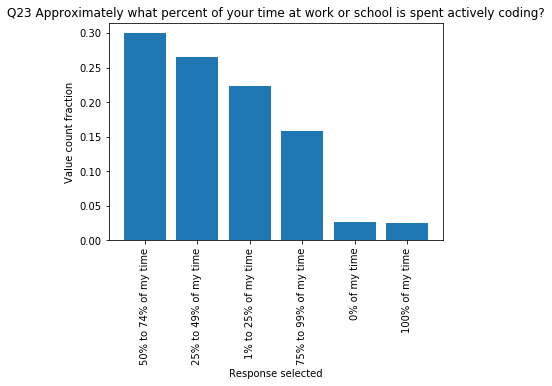

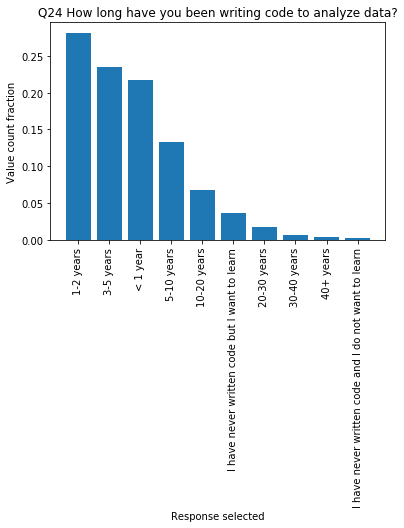

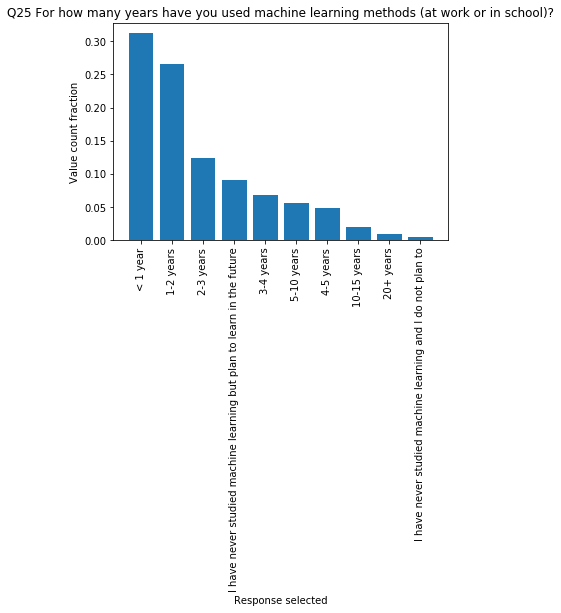

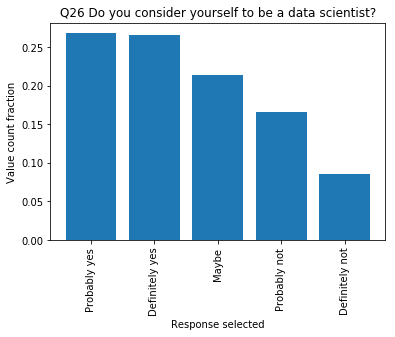

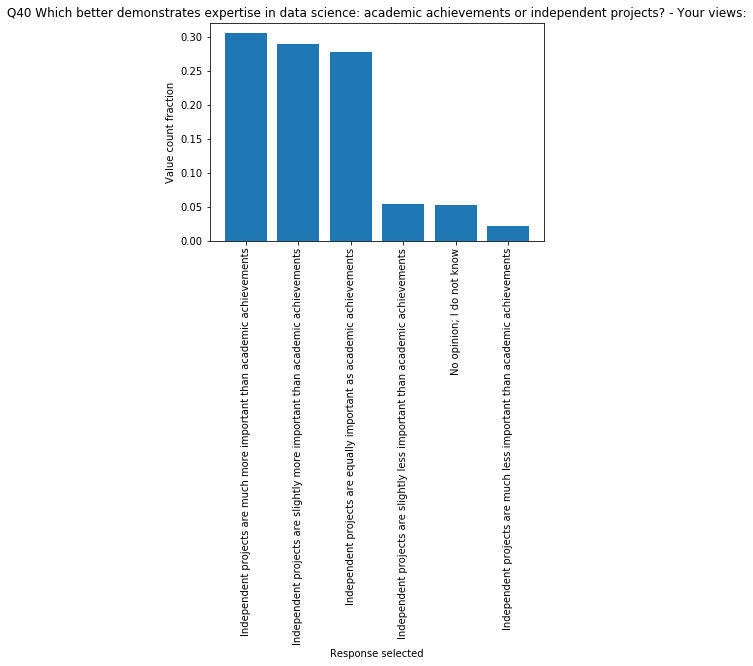

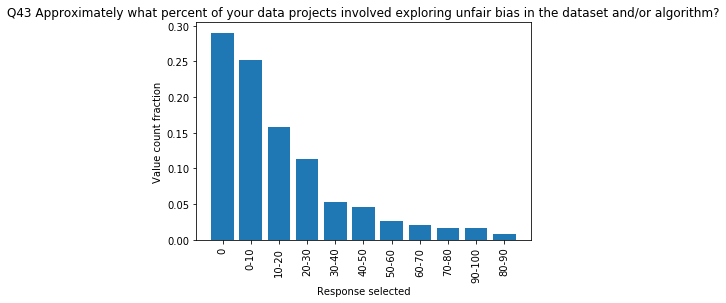

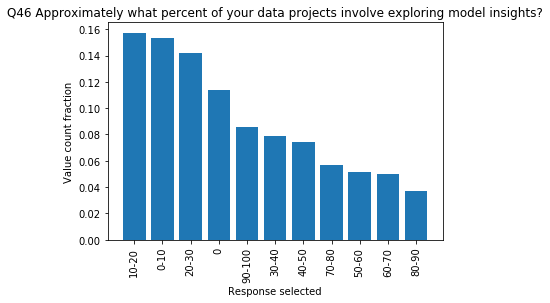

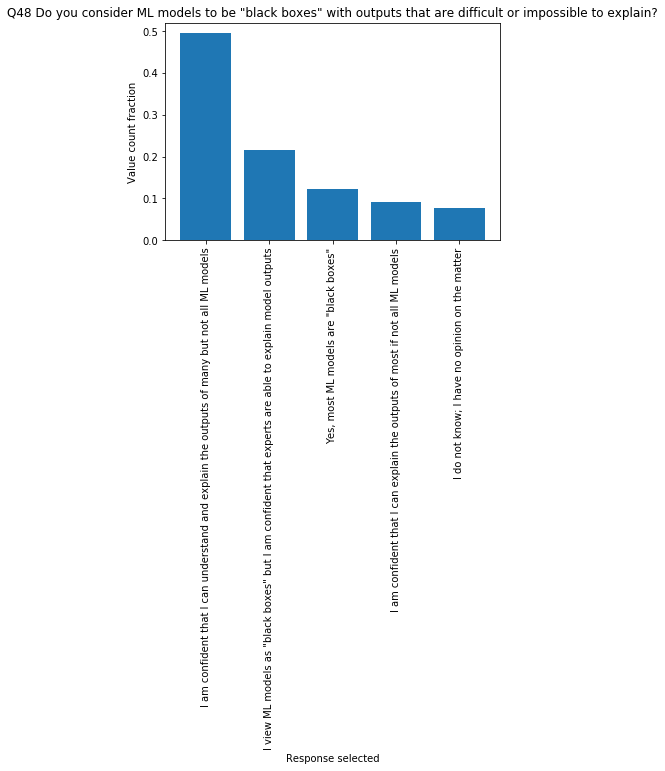

In [48]:
for col in cols:
    plt.figure()
    plt.bar(df_single[col].value_counts().index, np.array(df_single[col].value_counts())/sum(df_single[col].value_counts()))
    plt.xticks(df_single[col].value_counts().index, rotation='vertical')
    plt.xlabel('Response selected')
    plt.title(col+' '+ques_dict[col])
    plt.ylabel('Value count fraction')

In [49]:
print (cols)

['Q23', 'Q24', 'Q25', 'Q26', 'Q40', 'Q43', 'Q46', 'Q48']


Based on the above figures to observe the trends in value counts, Q 24,26,43 and 46 would be filled up with not NaN values from the same column, randomly, as there is no clear majority of any one category.

Q 23, 25 and 40 would however be filled up with a subset of the values that occur most frequently, as some categories for sure have a larger share.

Q 48 would be filled up with the most logical response i.e. "I do not know...", as it seems to be the better choice compared to random imputation.

Following steps fill-up the values in the columns.

In [50]:
for ques in ['Q24','Q26','Q43','Q46']:
    df[ques].fillna(np.random.choice(df[df[ques].notna()][ques]), inplace =True)

For Q23, top 4 frequently occurring values would be taken to fill up the empty rows.

In [51]:
df.Q23.value_counts()[:4]

50% to 74% of my time    4036
25% to 49% of my time    3571
1% to 25% of my time     3013
75% to 99% of my time    2141
Name: Q23, dtype: int64

In [52]:
label_list = []
for label in df.Q23.value_counts()[:4].index:
    label_list+= list(df[df['Q23'] == label]['Q23'])
np.random.shuffle(label_list)

In [53]:
df['Q23'].fillna(np.random.choice(label_list), inplace =True)

Similarly, for Q25, top 2 frequently occurring values would be taken to fill up the empty rows.

In [54]:
label_list = []
for label in df.Q25.value_counts()[:2].index:
    label_list+= list(df[df['Q25'] == label]['Q25'])
np.random.shuffle(label_list)

In [55]:
df['Q25'].fillna(np.random.choice(label_list), inplace =True)

Similarly, for Q40, top 3 frequently occurring values would be taken to fill up the empty rows.

In [56]:
label_list = []
for label in df.Q40.value_counts()[:3].index:
    label_list+= list(df[df['Q40'] == label]['Q40'])
np.random.shuffle(label_list)

In [57]:
df['Q40'].fillna(np.random.choice(label_list), inplace =True)

Q48 would be filled with label 'I do not know; I have no opinion on the matter' as it is the appropriate answer for the missing value samples.

In [58]:
df['Q48'].fillna('I do not know; I have no opinion on the matter', inplace =True)

So far, all the single part columns have been filled up with appropriate values.

Now we can move onto columns having multiple parts.

Following code creates a new list corresponding to those column names.

In [59]:
multi_part = []
for col in ques_list:
    if len(col_dict[col]) > 1:
        multi_part.append(col)

On close inspection, it was found that even within multi-part question columns, there are columns having 'Select all that apply' condition. This means more than one relevant choices can be selected or none at all. These responses are in a way, already in there one-hot encoded form where each sub-part column corresponds to the 'Selected choice' and the values are simply replaced by the same 'Selected choice' labels. Therefore, those column names were further saved in another list 'multi_part_multi_choice'.

In [60]:
multi_part_multi_choice = []
for ques in multi_part:
    ques_list = col_dict[ques]
    for ques_part in ques_list:
        if '(Select all that apply)' in ques_dict[ques_part]:
            multi_part_multi_choice.append(ques)
            break

In [61]:
len(multi_part_multi_choice), len(multi_part)

(21, 33)

The subset of columns for which there is no such condition as 'Select all that apply' are obtained.

In [62]:
multi_part_others = list(set(multi_part) - set(multi_part_multi_choice))

In [63]:
multi_part_others.sort()

Out of those columns, the ones having missing values are printed.

In [64]:
for col in multi_part_others:
    cols = col_dict[col]
    for col_name in cols:
        if sum(df[col_name].value_counts()) < len(df):
            print(col_name)

Q12_MULTIPLE_CHOICE
Q17
Q18
Q20
Q22
Q32
Q34_Part_1
Q34_Part_2
Q34_Part_3
Q34_Part_4
Q34_Part_5
Q34_Part_6
Q35_Part_1
Q35_Part_2
Q35_Part_3
Q35_Part_4
Q35_Part_5
Q35_Part_6
Q37
Q39_Part_1
Q39_Part_2
Q41_Part_1
Q41_Part_2
Q41_Part_3


These were manually examined in the following steps for the best strategy for filling data.

In [65]:
col_dict['Q12']

['Q12_MULTIPLE_CHOICE',
 'Q12_Part_1_TEXT',
 'Q12_Part_2_TEXT',
 'Q12_Part_3_TEXT',
 'Q12_Part_4_TEXT',
 'Q12_Part_5_TEXT',
 'Q12_OTHER_TEXT']

In [66]:
df['Q12_MULTIPLE_CHOICE'].value_counts()

Local or hosted development environments (RStudio, JupyterLab, etc.)    6935
Basic statistical software (Microsoft Excel, Google Sheets, etc.)       2692
Other                                                                   1246
Advanced statistical software (SPSS, SAS, etc.)                         1079
Cloud-based data software & APIs (AWS, GCP, Azure, etc.)                1020
Business intelligence software (Salesforce, Tableau, Spotfire, etc.)     885
Name: Q12_MULTIPLE_CHOICE, dtype: int64

In [67]:
sum(df['Q12_OTHER_TEXT'].value_counts())

15429

In [68]:
df[col_dict['Q12']].head()

,Q12_MULTIPLE_CHOICE,Q12_Part_1_TEXT,Q12_Part_2_TEXT,Q12_Part_3_TEXT,Q12_Part_4_TEXT,Q12_Part_5_TEXT,Q12_OTHER_TEXT
1,"Basic statistical software (Microsoft Excel, G...",1,-1,-1,-1,-1,-1
2,Local or hosted development environments (RStu...,-1,-1,-1,0,-1,-1
3,"Advanced statistical software (SPSS, SAS, etc.)",-1,1,-1,-1,-1,-1
4,"Basic statistical software (Microsoft Excel, G...",2,-1,-1,-1,-1,-1
5,Local or hosted development environments (RStu...,-1,-1,-1,3,-1,-1


On close inspection of Q12 it was found that the different part columns contain the same information provided in the 'Q12_MULTIPLE_CHOICE' in the form of vectorized counts. Therefore, the other other columns would be removed from the dataframe.

Following code drops those extra columns.

In [69]:
col_to_drop = col_dict['Q12'][1:]
df = df.drop(col_to_drop, axis=1)

In [70]:
for col_name in col_to_drop:
    col_dict['Q12'].remove(col_name)

In [71]:
col_dict['Q12']

['Q12_MULTIPLE_CHOICE']

In [72]:
print(sum(df[col_dict['Q12'][0]].value_counts())/len(df))

0.8981139412794089


Around 90% of the column is filled.

An interesting strategy for filling up these columns would be via a classification model trained on the data in single-part columns as predictors and the filled values as the training set output.

Let us see if it is possible to predict the classes of these variables using a decision tree or logistic model fitted over the responses to single part questions.

In [73]:
model = LogisticRegression(solver='liblinear',multi_class='ovr')

In [74]:
clf = DecisionTreeClassifier(random_state=56)

Input variables are taken as single_part columns excluding the 'Time to fill the survey' question which is at the first position in the list.
Output is the response category in Q12.

The categorical input was converted to numerical using get_dummies() function (one-hot encoding).

In [75]:
X = df[single_part[1:]]
y = df[col_dict['Q12']]
train_indices = y[y['Q12_MULTIPLE_CHOICE'].notna()].index
test_indices = y[y['Q12_MULTIPLE_CHOICE'].isna()].index
X = pd.get_dummies(X, prefix=single_part[1:])
X_train = X.loc[train_indices]
y_train = np.array(y.loc[train_indices])
X_test = X.loc[test_indices]

In [76]:
single_part[1:]

['Q1',
 'Q2',
 'Q3',
 'Q4',
 'Q5',
 'Q6',
 'Q8',
 'Q10',
 'Q23',
 'Q24',
 'Q25',
 'Q26',
 'Q40',
 'Q43',
 'Q46',
 'Q48']

In [77]:
len(X_train), len(X), len(train_indices), len(test_indices)

(13857, 15429, 13857, 1572)

The average cross-validation score for each of the models was looked at and since the logistic model had better cv score, it was chosen for imputation of the values.

NOTE: Since there is no explicit test set, the accuracy cannot be checked on the final predicted classes, which is why cross-val score is taken as the metric for selection.

In [78]:
dtcv = cross_val_score(clf,X_train,y_train,cv=10)

In [79]:
logcv = cross_val_score(model,X_train,y_train.ravel(),cv=10)

In [80]:
logcv.mean(), dtcv.mean()

(0.5521268104900531, 0.3846180410063968)

Logistic model was fitted on the single-part dataset.

In [81]:
model.fit(X_train,y_train.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Predictions for empty responses were made using the model and filled inplace.

In [82]:
y_pred_logistic = model.predict(X_test)

In [83]:
y_to_fill = pd.Series(data=y_pred_logistic,index=test_indices)

In [84]:
df[col_dict['Q12'][0]].fillna(value=y_to_fill, inplace=True)

In [85]:
col_dict['Q12']

['Q12_MULTIPLE_CHOICE']

The remaining multipart columns (not including multi-choice) were similarly observed to check whether or not imputation by classification/regression is possible. For each case the fraction of null values are displayed.

In [86]:
df[col_dict['Q18']].head()

,Q18,Q18_OTHER_TEXT
1,Python,-1
2,Python,-1
3,R,-1
4,R,-1
5,Python,-1


In [87]:
df[col_dict['Q17']].head()

,Q17,Q17_OTHER_TEXT
1,NaN,-1
2,Java,-1
3,SQL,-1
4,NaN,-1
5,NaN,-1


In [88]:
len(df[df[col_dict['Q17'][0]].notna()])/len(df)

0.7186467042582151

In [89]:
len(df[df[col_dict['Q18'][0]].notna()])/len(df)

0.8819106876660834

In [90]:
df[col_dict['Q20']].head()

,Q20,Q20_OTHER_TEXT
1,NaN,-1
2,NaN,-1
3,NaN,-1
4,NaN,-1
5,Keras,-1


In [91]:
len(df[df[col_dict['Q20'][0]].notna()])/len(df)

0.6260937196188995

In [92]:
len(df[df[col_dict['Q34'][0]].notna()])/len(df), len(df[df[col_dict['Q34'][1]].notna()])/len(df), len(df[df[col_dict['Q34'][2]].notna()])/len(df)

(0.7625251150431006, 0.7625251150431006, 0.7625251150431006)

In [93]:
df[col_dict['Q22']].head()

,Q22,Q22_OTHER_TEXT
1,NaN,-1
2,ggplot2,-1
3,NaN,-1
4,NaN,-1
5,Matplotlib,-1


In [94]:
len(df[df[col_dict['Q22'][0]].notna()])/len(df)

0.5953723507680342

In [95]:
df[col_dict['Q32']].head()

,Q32,Q32_OTHER
1,NaN,-1
2,Time Series Data,-1
3,NaN,-1
4,Numerical Data,-1
5,Image Data,-1


In [96]:
len(df[df[col_dict['Q32'][0]].notna()])/len(df)

0.6678333009268261

In [97]:
df[col_dict['Q34']].head()

,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_OTHER_TEXT
1,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,2,3,20,50,20,0,1
3,10,10,20,10,20,23,3
4,0,30,50,0,0,20,2
5,20,30,20,20,5,5,2


In [98]:
df[col_dict['Q35']].head()

,Q35_Part_1,Q35_Part_2,Q35_Part_3,Q35_Part_4,Q35_Part_5,Q35_Part_6,Q35_OTHER_TEXT
1,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,0,0,0,100,0,0,-1
3,20,40,20,20,0,0,-1
4,50,20,30,0,0,0,-1
5,75,5,20,0,0,0,-1


Program to check whether for each sample, we have entries in at least one column of each question having categorical answers.

In [99]:
len(df[df[col_dict['Q35'][0]].notna()])/len(df), len(df[df[col_dict['Q35'][1]].notna()])/len(df), len(df[df[col_dict['Q35'][2]].notna()])/len(df)

(0.7546827402942511, 0.7546827402942511, 0.7546827402942511)

In [100]:
df[col_dict['Q37']].head()

,Q37,Q37_OTHER_TEXT
1,NaN,-1
2,DataCamp,-1
3,Coursera,-1
4,NaN,-1
5,Udacity,-1


In [101]:
len(df[df[col_dict['Q37'][0]].notna()])/len(df), len(df[df[col_dict['Q37'][1]].notna()])/len(df)

(0.4724220623501199, 1.0)

In [102]:
df[col_dict['Q39']].head()

,Q39_Part_1,Q39_Part_2
1,Slightly worse,No opinion; I do not know
2,Slightly worse,Slightly better
3,Slightly better,Much better
4,Slightly better,Neither better nor worse
5,Slightly better,Slightly better


In [103]:
len(df[df[col_dict['Q39'][0]].notna()])/len(df), len(df[df[col_dict['Q39'][1]].notna()])/len(df)

(0.7602566595372351, 0.7602566595372351)

In [104]:
df[col_dict['Q41']].head()

,Q41_Part_1,Q41_Part_2,Q41_Part_3
1,NaN,NaN,NaN
2,Very important,Very important,Very important
3,Not at all important,Slightly important,Very important
4,Slightly important,Slightly important,Very important
5,Very important,Very important,Very important


In [105]:
len(df[df[col_dict['Q41'][0]].notna()])/len(df), len(df[df[col_dict['Q41'][1]].notna()])/len(df), len(df[df[col_dict['Q41'][2]].notna()])/len(df)

(0.7179337610992287, 0.7179337610992287, 0.7179337610992287)

Out of Q 12, 17, 18, 20, 22, 32, 34, 35, 37, 39 and 41, only Q37 has null values greater than 50% , therefore those null values would be replaced by a randomly drawn value from the filled ones.

For Q34 and Q35, since they are percentage values, regression models can be used to predict values. However, the resulting predicted values (not included here) have a range beyond 0-100. Hence, as an alternative, a normal distribution was generated from the mean and standard deviation of the not NaN values, and a random sample drawn from this distribution would be used to fill-in the rounded percentages of various parts (except last one which would be filled by 100 - sum of previous parts).

For all remaining columns, the "OTHER_TEXT" column would be dropped and the main column filled using logistic regression model trained on filled samples.

In [106]:
col_to_drop = col_dict['Q37'][1:]
df = df.drop(col_to_drop, axis=1)

In [107]:
for col_name in col_to_drop:
    col_dict['Q37'].remove(col_name)

In [108]:
for ques in ['Q17','Q18','Q20','Q22','Q32']:
    col_to_drop = col_dict[ques][-1]
    df = df.drop(col_to_drop, axis=1)
    col_dict[ques].remove(col_to_drop)

In [109]:
for ques in ['Q34','Q35']:
    col_to_drop = col_dict[ques][-1]
    df = df.drop(col_to_drop, axis=1)
    col_dict[ques].remove(col_to_drop)

'Q7' too, though not having any null values, has an 'OTHER_TEXT' column which needs to be removed.

In [110]:
df = df.drop('Q7_OTHER_TEXT',axis = 1)

In [111]:
col_dict['Q7'].remove('Q7_OTHER_TEXT')

Filling Q37 with random values (logic specified earlier).

In [112]:
df['Q37'].fillna(np.random.choice(df[df['Q37'].notna()]['Q37']), inplace =True)

Using Logistic model to fill-in the remaining null values (except Q 34 and 35 which are dealt with later) as specified earlier.

The imputation was done in a loop with an iteration for each column.

In [113]:
ques_to_log_fill = ['Q17','Q18','Q20','Q22','Q32','Q39','Q41']
predictors = single_part[1:]
predictors.append('Q12_MULTIPLE_CHOICE')
for ques in ques_to_log_fill:
    col_list = col_dict[ques]
    for col_name in col_list:
        X = df[predictors]
        y = df[col_name]
        train_indices = y[y.notna()].index
        test_indices = y[y.isna()].index
        X = pd.get_dummies(X, prefix=predictors)
        X_train = X.loc[train_indices]
        y_train = np.array(y.loc[train_indices])
        X_test = X.loc[test_indices]
        model.fit(X_train,y_train.ravel())
        y_pred_logistic = model.predict(X_test)
        y_to_fill = pd.Series(data=y_pred_logistic,index=test_indices)
        df[col_name].fillna(value=y_to_fill, inplace=True)
        predictors.append(col_name)

For Q34 and Q35, as mentioned before, the values were filled using a distribution created from the mean and standard deviation of the not NaN values.

Following 2 blocks of code contain the steps to execute that.

In [114]:
col_list = col_dict['Q34']
last_col = col_list[-1]
col_list = col_list[:-1]

slice_array = np.array(df[col_list].astype(float))

array_means = np.nanmean(slice_array,axis=0)
array_stds = np.nanstd(slice_array,axis=0)



i=0
for col_name in col_list:
    df[col_name].fillna(np.round(np.random.normal(loc=array_means[i],scale=array_stds[i])), inplace =True)
    df[col_name] = df[col_name].astype(float)
    df[col_name] = df[col_name].apply(lambda x: 0 if x < 0 else x)
    i = i+1

df[col_list+[last_col]] = df[col_list+[last_col]].astype(float)

slice_array = np.array(df[col_list])

last_col_array = np.ones(len(df))*100 - np.sum(slice_array,axis=1)

df[last_col] = last_col_array

In [115]:
col_list = col_dict['Q35']
last_col = col_list[-1]
col_list = col_list[:-1]

df[col_list+[last_col]] = df[col_list+[last_col]].astype(float)

slice_array = np.array(df[col_list])

array_means = np.nanmean(slice_array,axis=0)
array_stds = np.nanstd(slice_array,axis=0)

i=0
for col_name in col_list:
    df[col_name].fillna(np.round(np.random.normal(loc=array_means[i],scale=array_stds[i])), inplace =True)
    df[col_name] = df[col_name].astype(float)
    df[col_name] = df[col_name].apply(lambda x: 0 if x < 0 else x)
    i = i+1

slice_array = np.array(df[col_list])

last_col_array = np.ones(len(df))*100 - np.sum(slice_array,axis=1)

df[last_col] = last_col_array

All 'OTHER_TEXT' columns were removed for the reasons specified earlier.

In [116]:
for ques in multi_part_multi_choice:
    col_list = col_dict[ques]
    if 'OTHER_TEXT' in col_list[-1]:
        df = df.drop(col_list[-1], axis=1)
        col_dict[ques].remove(col_list[-1])

A list of columns in the multi-part and multi-choice category was created.

In [117]:
multi_choice_col_list = []
for ques in multi_part_multi_choice:
    col_list = col_dict[ques]
    multi_choice_col_list+=col_list

A list of columns other than multipart-multichoice was also created ('remaining_col_list')

In [118]:
remaining_col_list = list(set(df.columns)-set(multi_choice_col_list))

In [119]:
remaining_col_list.sort()

In [120]:
len(remaining_col_list) + len(multi_choice_col_list), len(df.columns)

(234, 234)

All the remaining NaN values were replaced with zeros (as they all belong to multi-part-multi-choice category and are one-hot encoded already).

In [121]:
df_new = df.fillna(0)

Finally all the data is cleaned!!! This can be seen from the heatmap of the modified dataframe.

Text(0.5, 50.09375, 'Features')

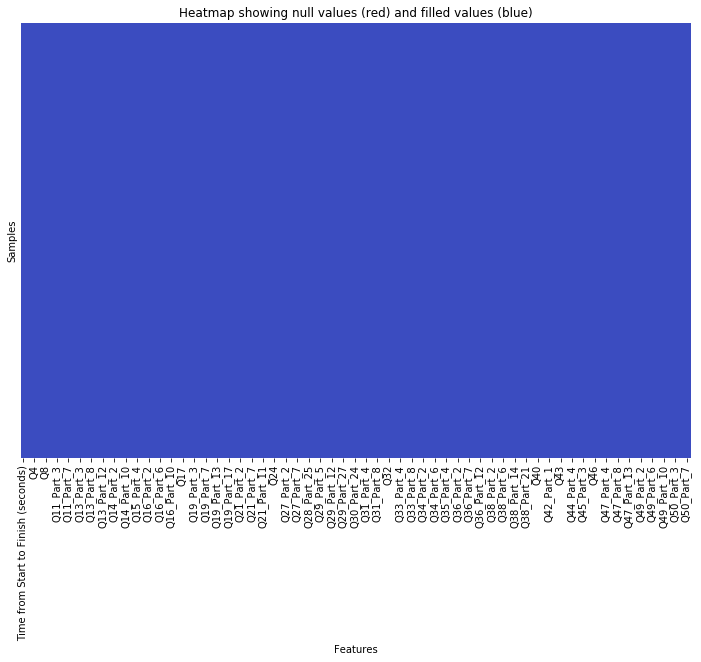

In [122]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(df_new.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)
ax.set_title('Heatmap showing null values (red) and filled values (blue)')
ax.set_ylabel('Samples')
ax.set_xlabel('Features')

### Part 2: Exploratory Data Analysis ###

A new column of salaries was added to the dataframe for EDA.

In [123]:
df['Salary'] = salaries

An attempt was made to convert all numerical values to float.

In [124]:
for col_name in df.columns:
    try:
        df[col_name] = df[col_name].astype(float)
    except:
        continue

In [125]:
df.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q10,...,Q49_Part_11,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,index,Salary
1,434.0,Male,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,Manufacturing/Fabrication,5-10,No (we do not use ML methods),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,18668.0
2,718.0,Female,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,I am a student,0-1,I do not know,...,NaN,NaN,Too time-consuming,NaN,NaN,NaN,NaN,NaN,1.0,2726.0
3,731.0,Male,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,I am a student,0-1,I do not know,...,NaN,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,2.0,682.0
4,959.0,Male,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,Academics/Education,10-15,No (we do not use ML methods),...,NaN,Too expensive,NaN,NaN,NaN,NaN,I had never considered making my work easier f...,NaN,3.0,11957.0
5,1758.0,Male,18-21,India,Master’s degree,"Information technology, networking, or system ...",Other,Other,0-1,"We recently started using ML methods (i.e., mo...",...,NaN,NaN,NaN,NaN,NaN,Not enough incentives to share my work,NaN,NaN,4.0,2696.0


#### Figure 1: Box-plot for distribution of salaries throughout the countries.

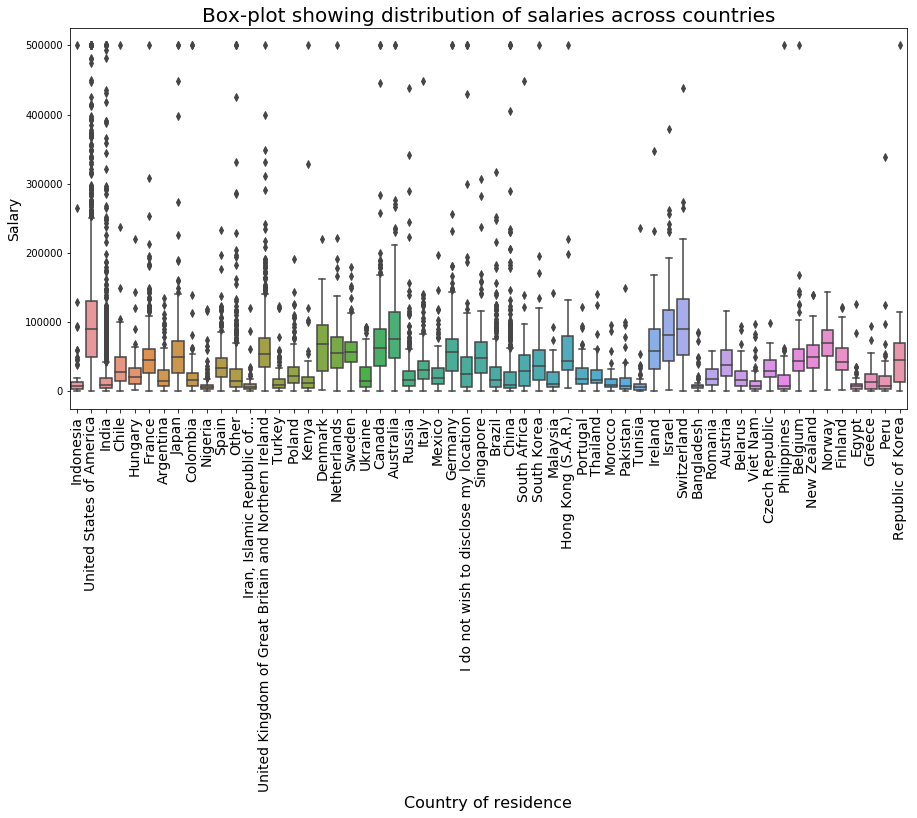

In [184]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(x='Q3', y="Salary", data = df)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90,fontsize=14)
ax.set_xlabel('Country of residence',fontsize=16)
ax.set_ylabel('Salary',fontsize=14)
ax.set_title('Box-plot showing distribution of salaries across countries', fontsize=20)
#plt.savefig('Box_1.png',bbox_inches='tight')

It can be seen from the plot that the highest median salaries are for United States and Switzerland. In addition to it, there are a number of outliers in the US having a very high salary. In fact, the cluster of those outliers together form the highest paying cluster in the world.

The median and the spread itself seem to be the lowest for coutries like Nigeria, Tunisia, Egypt, Bangladesh and a few others.

This provides a hint on the importance of the 'place of residence' feature for salary prediction as there is a lot of variation in box-plots among different countries.

In [127]:
for ques in single_part:
    print(ques, ques_dict[ques])

Time from Start to Finish (seconds) Duration (in seconds)
Q1 What is your gender? - Selected Choice
Q2 What is your age (# years)?
Q3 In which country do you currently reside?
Q4 What is the highest level of formal education that you have attained or plan to attain within the next 2 years?
Q5 Which best describes your undergraduate major? - Selected Choice
Q6 Select the title most similar to your current role (or most recent title if retired): - Selected Choice
Q8 How many years of experience do you have in your current role?
Q10 Does your current employer incorporate machine learning methods into their business?
Q23 Approximately what percent of your time at work or school is spent actively coding?
Q24 How long have you been writing code to analyze data?
Q25 For how many years have you used machine learning methods (at work or in school)?
Q26 Do you consider yourself to be a data scientist?
Q40 Which better demonstrates expertise in data science: academic achievements or independent p

#### Figure 2: Box-plot for salary distribution among undegraduate majors ####

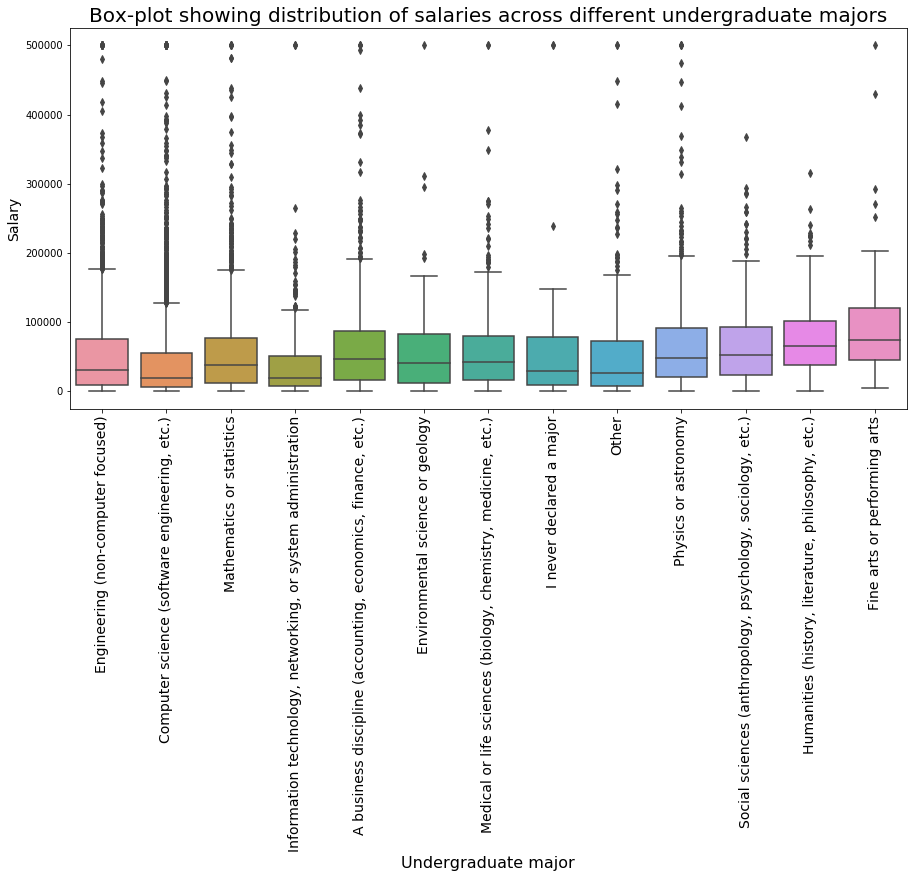

In [183]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(x='Q5', y="Salary", data = df)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90,fontsize=14)
ax.set_xlabel('Undergraduate major',fontsize=16)
ax.set_ylabel('Salary',fontsize=14)
ax.set_title('Box-plot showing distribution of salaries across different undergraduate majors', fontsize=20)
#plt.savefig('Box_3.png',bbox_inches='tight')

From the above plot, a surprising revelation is that people with an undergraduate major in 'Fine Arts...' have a higher median salary compared to others. However, there are only a few outliers for that set. on the other hand, people with engineering or computer science undergraduates seem to have the maximum number of outliers on the higher salary side, hinting skewness in the data.

Overall, the location of box-plots is more or less uniform indicating a lower importance of this feature than the country of residence.

#### Figure 3: Box-plot for salaries vs. experience years

Text(0.5, 1.0, 'Box-plot showing distribution of salaries for different experience years')

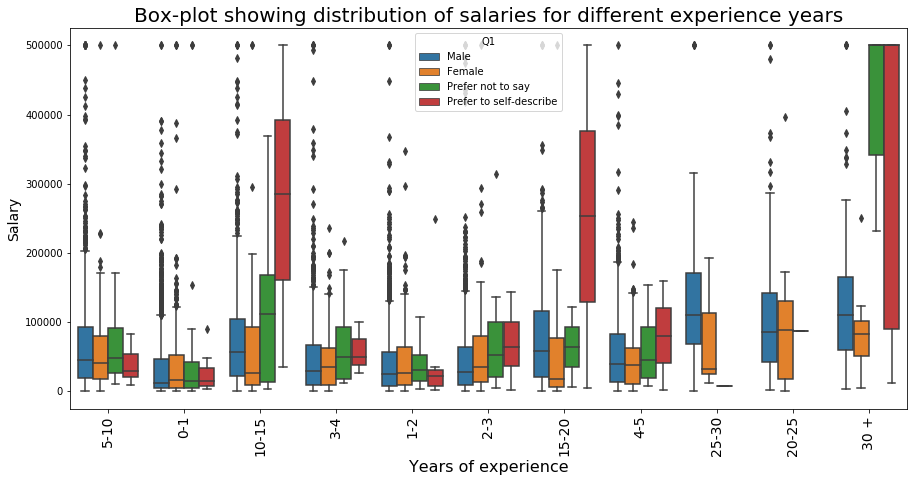

In [129]:
plt.figure(figsize=(15,7))
ax = sns.boxplot(x='Q8', y="Salary", data = df,hue='Q1')
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90,fontsize=14)
ax.set_xlabel('Years of experience',fontsize=16)
ax.set_ylabel('Salary',fontsize=14)
ax.set_title('Box-plot showing distribution of salaries for different experience years', fontsize=20)

From the above plot we can make the following observations:
1. It can be seen that the medians for experience upto 5-10 years are more or less at similar levels (though there is only a slight increase in each experience class) and the median salaries go up beyond those years.
2. Also, as the experience years increase, the outlier salary clusters above the median also shift upwards.
3. For Male and Female, the salary quartiles remain more or less similar for the initial years (upto 5-10 years) but thereafter the disparity increases with Males having higher median salary. The exception is only in 20-25 years of experience case.
4. For 10-15, 15-20 and 30+ years of experience classes, the people who preferred to self-describe their gender have higher median salary.

##### Part 2b (Feature importance visualization) has been covered after Part 3

### Part-3: Feature selection ###

The dataframe was split into 2 parts: one that required one-hot encoding for converting categorical variables to numerical data and the other that was already in the encoded form. for_dummies is the one that requires encoding and for_encoding is th one that requires a slight modification of changing the labels to ones and NaNs to zeros.

On-hot encoding

PROS: 
It was used because it is easier to grab the importance of each individual choice made by the respondent as a separate variable.

CONS:
It increases the number of features which may sometimes make the fitting process time-intensive.

In [130]:
for_dummies = df[remaining_col_list]

In [131]:
prefix_labels = for_dummies.dtypes[for_dummies.dtypes == object]

In [132]:
prefix_labels = list(prefix_labels.index)

Dummies stored as X1.

In [133]:
X1 = pd.get_dummies(for_dummies, prefix=prefix_labels)

In [134]:
for_encoding = df[multi_choice_col_list]

In [135]:
df['Q11_Part_1'].value_counts().index[0]

'Analyze and understand data to influence product or business decisions'

In [136]:
new_col_names = []
for col_name in multi_choice_col_list:
    slice_value = df[col_name].value_counts().index[0]
    new_col_names.append(col_name.split('_')[0]+'_'+slice_value)

In [137]:
len(new_col_names), len(for_encoding.columns)

(191, 191)

New column heads (that make more sense) for the 'for_encoding' dataframe were created and the old ones replaced.

In [138]:
for_encoding.columns = new_col_names

In [139]:
for_encoding.columns

Index(['Q11_Analyze and understand data to influence product or business decisions',
       'Q11_Build and/or run a machine learning service that operationally improves my product or workflows',
       'Q11_Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data',
       'Q11_Build prototypes to explore applying machine learning to new areas',
       'Q11_Do research that advances the state of the art of machine learning',
       'Q11_None of these activities are an important part of my role at work',
       'Q11_Other', 'Q13_Jupyter/IPython', 'Q13_RStudio', 'Q13_PyCharm',
       ...
       'Q49_Define relative rather than absolute file paths',
       'Q49_Include a text file describing all dependencies',
       'Q49_None/I do not make my work easy for others to reproduce',
       'Q50_Too expensive', 'Q50_Too time-consuming',
       'Q50_Requires too much technical knowledge',
       'Q50_Afraid that others will use my work with

In the following step the non NaN values are being replaced by ones. The code throws a warning as the changes are in place.

In [140]:
for_encoding[for_encoding.notna()] = 1

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:3414: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)


In the following step, the Nan is replaced by zeros.

In [141]:
for_encoding.fillna(value = 0,inplace=True)

/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [142]:
X2 = for_encoding

The 2 data frames are concatenated into one.

In [143]:
X = pd.concat([X1,X2], axis=1)

The total number of features now for the whole dataset are 533

In [144]:
len(X.columns)

533

The salaries series is rid of its first row which containes the text form of the question.

In [145]:
salaries = salaries[1:].astype(float)

Conversion to numpy array

In [146]:
y = np.array(salaries)

The variables scaled to values between 0 and 1. This is because, we have a combination of one-hot encoded data and numerical data. This was done using MinMaxScaler.

In [147]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


For feature selection, a form of regularization (Lasso) was used to predict feature importances. LassoCV was used in combination with SelectFromModel function for feature selection. Cross-validation was kept at 5 folds. An arbitrary threshold was chosen for the model, which is later modified.

In [148]:
clf = LassoCV(cv=5)

In [149]:
sfm = SelectFromModel(clf, threshold=0.25)

In [150]:
y

array([ 18668.,   2726.,    682., ...,  15180., 253671.,  15349.])

In [151]:
np.any(np.isnan(y))

False

In [152]:
np.all(np.isfinite(y))

True

In [153]:
sfm.fit(X_scaled, y)
n_features = sfm.transform(X_scaled).shape[1]

Using the arbitrary threshold, we have 353 features (value may change depending upon the random filling in data cleaning steps) now instead of 533. The threshold was iteratively modified to give a total of 100 features in the end.

In [154]:
n_features

352

In [155]:
while n_features > 100:
    sfm.threshold += 1
    X_transform = sfm.transform(X_scaled)
    n_features = X_transform.shape[1]

In [156]:
sfm.get_params(deep=True)

{'estimator__alphas': None,
 'estimator__copy_X': True,
 'estimator__cv': 5,
 'estimator__eps': 0.001,
 'estimator__fit_intercept': True,
 'estimator__max_iter': 1000,
 'estimator__n_alphas': 100,
 'estimator__n_jobs': None,
 'estimator__normalize': False,
 'estimator__positive': False,
 'estimator__precompute': 'auto',
 'estimator__random_state': None,
 'estimator__selection': 'cyclic',
 'estimator__tol': 0.0001,
 'estimator__verbose': False,
 'estimator': LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
     max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
     positive=False, precompute='auto', random_state=None,
     selection='cyclic', tol=0.0001, verbose=False),
 'max_features': None,
 'norm_order': 1,
 'prefit': False,
 'threshold': 3066.25}

The respective column headings (feature names) were saved in a list.

In [157]:
selected_col_names = []
for index in sfm.get_support(indices=True):
    selected_col_names.append(X.columns[index])

The estimator was fit to the data to obtain feature coefficients.

In [158]:
sfm.get_params()['estimator'].fit(X_transform,y)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [159]:
importance=sfm.get_params()['estimator'].coef_

The parameters were changed to their absolute values.

In [160]:
importance = np.absolute(importance)

These wer then plotted to obtain a visual represeantation of feature importances.

### Exploratory Data Analysis (Part 2 b continued)

#### Figure 4: Plot of feature importance

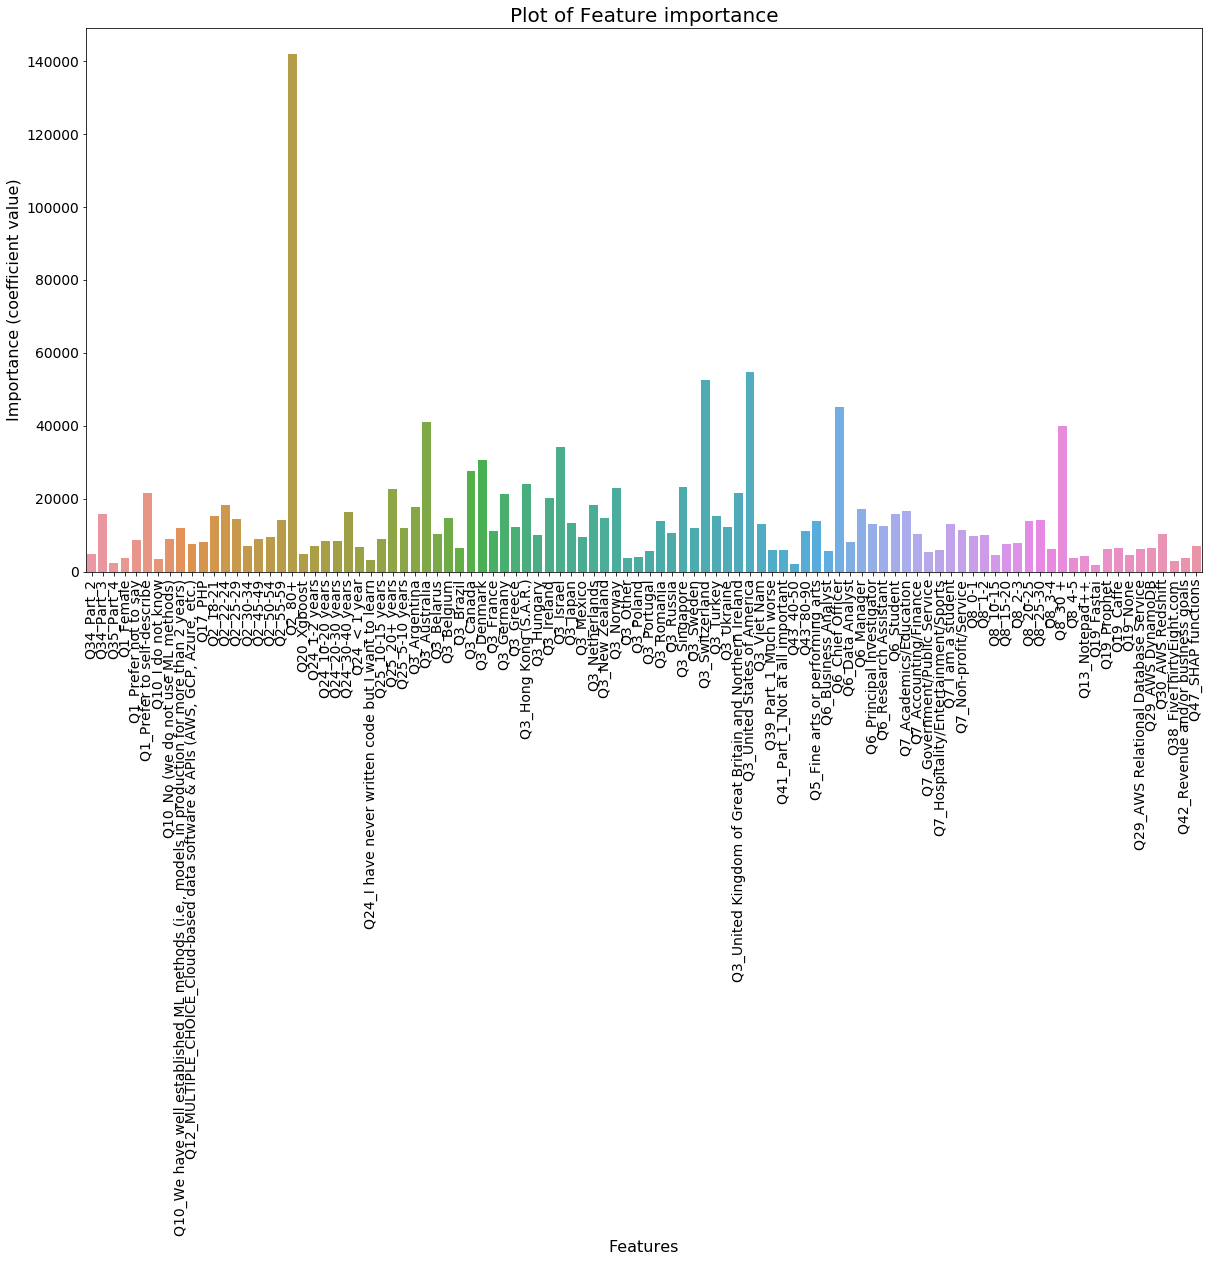

In [182]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x=selected_col_names,y=importance)
ax.set_xticklabels(selected_col_names,rotation='vertical',fontsize=14)
ax.set_ylabel('Importance (coefficient value)',fontsize=16)
ax.set_xlabel('Features',fontsize=16)
ax.tick_params(axis='y',labelsize=14)
ax.set_title('Plot of Feature importance', fontsize=20)
#plt.savefig('Feature_importance.png',bbox_inches='tight')

The above plot shows that the top 5 features for predicting the salary are:
1. Whether or not you are 80+ years old (which is logical as at that age group, a person is usually working at the highest level of any firm)
2. Whether or not you live in the United States (which is again logical as the largest scope for data scientist and related jobs are in US)
3. Whether or not you live in Switzerland.
4. Wheher or not your job title is 'Chief Officer'
5. Whether or not you have 30+ years of experience (we already saw a hint of that in the previous plots in Part 2).

In [162]:
X_transform

array([[0.29, 0.12, 0.29, ..., 0.  , 0.  , 0.  ],
       [0.03, 0.2 , 1.  , ..., 0.  , 0.  , 0.  ],
       [0.1 , 0.2 , 0.2 , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.29, 0.12, 0.29, ..., 0.  , 0.  , 0.  ],
       [0.29, 0.12, 0.29, ..., 0.  , 0.  , 0.  ],
       [0.29, 0.12, 0.29, ..., 0.  , 0.  , 0.  ]])

The data corresponding to these 100 features was stroed in a new dataframe (df_sel) with same index and the updated column list. This will be used for further analysis.

In [163]:
df_sel = pd.DataFrame(data = X_transform, index=df.index, columns=selected_col_names)

In [164]:
df_sel.head()

,Q34_Part_2,Q34_Part_3,Q35_Part_4,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q10_I do not know,Q10_No (we do not use ML methods),"Q10_We have well established ML methods (i.e., models in production for more than 2 years)","Q12_MULTIPLE_CHOICE_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)",...,Q19_Fastai,Q19_Prophet,Q19_Caffe,Q19_None,Q29_AWS Relational Database Service,Q29_AWS DynamoDB,Q30_AWS Redshift,Q38_FiveThirtyEight.com,Q42_Revenue and/or business goals,Q47_SHAP functions
1,0.29,0.12,0.29,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.03,0.20,1.00,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.10,0.20,0.20,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.30,0.50,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.30,0.20,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Part 4: Model implementation ###

The four models chosen for regression modelling were linear regression, Random Forest regression, K Nearest Neighbors regression and Gradient Boosting regression

Defining dictionaries for model names and model estimator instances.

In [165]:
model_names = {'lr': 'Linear Regression',
              'rfr': 'Random Forest Regression',
              'knr': 'K Nearest Neighbors Regression',
              'gbr': 'Gradient Boosting Regressor'}

In [166]:
models = {
    'lr': LinearRegression(),
    'rfr': RandomForestRegressor(),
    'knr': KNeighborsRegressor(),
    'gbr': GradientBoostingRegressor()
}

Defining dataframes to store cross-validation results.

In [185]:
resultDF = pd.DataFrame(columns=['model','hyperparams','train_acc','train_std','test_acc','test_std'])
MSEdf = pd.DataFrame(index = ['Fold_1','Fold_2','Fold_3','Fold_4','Fold_5','Fold_6','Fold_7','Fold_8','Fold_9','Fold_10'])
df_idx = 0

Defining a function for cross-validation (minor modifications made to the function used in Assignment-2 Tutorial notebook)

In [186]:
def crossValidate(typ, model, X, y, hyperparams='default', verbose=0):
    global df_idx
    
    # Update model hyperparameters if given
    if hyperparams is not 'default':
        model.set_params(**hyperparams)
    
    # Initialize scaler class
    #scaler = StandardScaler()
    
    # Get kFolds
    kfold = KFold(n_splits=10)
    kfold.get_n_splits(X)

    # Initialize storage vectors
    trainACC = np.zeros(10)
    testACC = np.zeros(10)
    trainMSE = np.zeros(10)
    testMSE = np.zeros(10)
    np_idx = 0

    # Loop through folds
    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X.values[train_idx], X.values[test_idx]
        y_train, y_test = y.values[train_idx], y.values[test_idx]

        # Scale data
        #X_train = scaler.fit_transform(X_train)
        #X_test = scaler.transform(X_test)

        # Fit to training set
        model.fit(X_train, y_train)

        # Make predictions on testing set
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Compute training and testing accuracy
        trainACC[np_idx] = model.score(X_train, y_train)*100
        testACC[np_idx] = model.score(X_test, y_test)*100
        
        trainMSE[np_idx] = mean_squared_error(y_train,y_train_pred)
        testMSE[np_idx] = mean_squared_error(y_test,y_test_pred)
        
        np_idx += 1
        
        # Print fold accuracy if verbose level 2
        if verbose == 2:
            print ("    Fold {}: Test Accuracy: {} Train Accuracy: {}%".format(np_idx, round(testACC[np_idx-1],3), round(trainACC[np_idx-1],3)))   

    # Print average accuracy if verbose level 1
    if verbose == 1 or verbose == 2:
        print ("  Average test Score: {}%({}%)".format(round(np.mean(testACC),3),round(np.std(testACC),3)))
        print ("  Average training Score: {}%({}%)".format(round(np.mean(trainACC),3),round(np.std(trainACC),3)))
    # Update dataframe
    resultDF.loc[df_idx, 'model'] = typ
    resultDF.loc[df_idx, 'hyperparams'] = str(hyperparams)
    resultDF.loc[df_idx, 'train_acc'] = trainACC.mean()
    resultDF.loc[df_idx, 'train_std'] = trainACC.std()
    resultDF.loc[df_idx, 'test_acc'] = testACC.mean()
    resultDF.loc[df_idx, 'test_std'] = testACC.std()
    df_idx += 1                                         
    
    MSEdf[typ+'_train_MSE'] = trainMSE
    MSEdf[typ+'_test_MSE'] = testMSE
    
    # Return average testing accuracy, and fitted model
    return testACC.mean(), model

In [187]:
salaries.dtypes

dtype('float64')

Performing CV for all 4 models by iterating over a loop.

In [188]:
for name, m in models.items():
    print ("Fitting " + model_names[name] + " model")
    _, models[name] = crossValidate(model_names[name], m, df_sel, salaries, 'default', 2)

Fitting Linear Regression model
    Fold 1: Test Accuracy: 40.72 Train Accuracy: 47.22%
    Fold 2: Test Accuracy: 53.587 Train Accuracy: 46.256%
    Fold 3: Test Accuracy: 58.426 Train Accuracy: 46.049%
    Fold 4: Test Accuracy: 46.317 Train Accuracy: 47.459%
    Fold 5: Test Accuracy: 44.701 Train Accuracy: 47.732%
    Fold 6: Test Accuracy: 44.034 Train Accuracy: 47.721%
    Fold 7: Test Accuracy: 46.366 Train Accuracy: 47.519%


KeyboardInterrupt: 

##### Model accuracy across folds:
1. For linear regression (LR), the standard deviation for accuracy on the test set across the 10 folds is low (9.667%) which is good. However, the average accuracy itself is not very high (only 43.628%) but still good compared to others. The average train accuracy was also close to the test accuracy (47.64%) with a small standard deviation of 0.89%
2. For random forest regression (RFR), the test accuracy is lower than linear regression (~31.972%) with a slightly higher standard deviation of 11.626% which is the highest among all models. But the standard deviation on training accuracy is the lowest (0.56%).
3. For k nearest neighbours (KNN), the test accuracy is the lowest (30.035%) with a standard deviation of 10.19%. for Training set, the standard deviation of accuracy across folds (0.95%) is the highest among the 4 models.
4. For Gradient Boosting regression (GBR), the test accuracy is the best (43.88%) with a low standard deviation (8.798%). The average training accuracy is also somewhat close to the test accuracy with a standard deviation of 0.84%.

###### Overall, Gradient Boosting regression gives the best accuracy on the test dataset with the lowest std dev.

For any model, bias is a measure of how much predicted values differ from the true values and variance is a measure of how predictions made on the same value vary with different realizations of the model. Therefore, for this case, higher the accuracy on the training set, higher the variance (more overfitting) and lower is the bias in the model. However, our objective is to have the best test accuracy (lowest prediction error on the test set). In order to have the best bias-variance trade-off, the testing accuracies need to be as high as possible and closer to the training accuracies. For gradient boosting both the training and the testing accuracies are higher than all other models indicating better model suitability and fitting. Though it is closely followed by linear regression.

###### Model descriptions
Each model was chosen keeping in mind the PROS for each.

LR

PROS:
1. Simplest to execute.
2. Fastest to solve (solution of linear equations for optimizing loss function)
3. Easy to get feature parameters and importances (in short easy to understand)

CONS:
1. Not able to capture complex functional relations.
2. Needs a lot of effort in feature engineering for getting a best fit for capturing complex relations between features and target variable.

RFR

PROS:
1. It is ensemble method, therefore there is a step similar to bootstrapping involved which basically, encompasses several decision trees working together.
2. Good results with large data sets.
3. Does not require feature engineering.

CONS:
1. Difficult to interpret unlike decision trees.
2. May overfit the data.

KNN

PROS:
1. Easy to understand.
2. Less hyperparameters for tuning.

CONS:
1. Very slow.
2. Does work well with large number of features.

GBR

PROS:
1. Good predictive accuracy
2. Flexible (can work on several loss functions and tweak a lot of parameters for obtaining higher accuracy)

CONS:
1. Overfitting
2. Not easily interpretable

In [171]:
MSEdf

,lr_train_MSE,lr_test_MSE,rfr_train_MSE,rfr_test_MSE,knr_train_MSE,knr_test_MSE,gbr_train_MSE,gbr_test_MSE,Linear Regression_train_MSE,Linear Regression_test_MSE,Random Forest Regression_train_MSE,Random Forest Regression_test_MSE,K Nearest Neighbors Regression_train_MSE,K Nearest Neighbors Regression_test_MSE,Gradient Boosting Regressor_train_MSE,Gradient Boosting Regressor_test_MSE
Fold_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.143297e+09,1.103127e+09,5.468049e+08,1.360591e+09,1.769698e+09,1.441461e+09,1.923829e+09,1.072703e+09
Fold_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.041592e+09,2.008927e+09,4.813291e+08,2.477587e+09,1.700963e+09,2.584235e+09,1.838836e+09,2.033851e+09
Fold_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.095421e+09,1.529720e+09,5.399403e+08,1.943441e+09,1.745176e+09,2.057121e+09,1.869820e+09,1.544260e+09
Fold_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.088305e+09,1.602089e+09,5.180378e+08,1.733355e+09,1.738385e+09,1.992588e+09,1.883553e+09,1.610027e+09
Fold_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.030005e+09,2.113255e+09,4.993738e+08,2.665406e+09,1.685020e+09,2.659099e+09,1.814573e+09,2.165832e+09
Fold_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.026187e+09,2.151848e+09,4.780912e+08,2.712291e+09,1.686819e+09,2.605229e+09,1.805002e+09,2.300985e+09
Fold_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.025244e+09,2.164866e+09,4.847628e+08,2.408399e+09,1.686250e+09,2.496602e+09,1.811565e+09,2.132571e+09
Fold_8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.874806e+09,3.624545e+09,4.281929e+08,4.420490e+09,1.589181e+09,4.428246e+09,1.695932e+09,3.536040e+09
Fold_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.007649e+09,2.322648e+09,4.706533e+08,2.956496e+09,1.682240e+09,2.823315e+09,1.805661e+09,2.242387e+09
Fold_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.996373e+09,2.425082e+09,4.491197e+08,2.834432e+09,1.652586e+09,2.910924e+09,1.790931e+09,2.347804e+09


In [172]:
resultDF

,model,hyperparams,train_acc,train_std,test_acc,test_std
0,Linear Regression,default,47.5548,0.895634,43.5346,9.66913
1,Random Forest Regression,default,87.3767,0.706065,31.7247,11.3793
2,K Nearest Neighbors Regression,default,56.2995,0.780629,30.0164,10.7366
3,Gradient Boosting Regressor,default,52.9423,0.798334,43.7343,8.88715


Function for plotting learning curve

In [173]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,
                        train_sizes=np.linspace(.1, 1.0, 5), scoring="neg_mean_squared_error"):
    
    plt.figure(figsize=(10,6))
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel("MSE")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = -np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = -np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,\
                     train_scores_mean + train_scores_std, alpha=0.1, \
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,\
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training Error")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation Error")
    plt.legend(loc="best")
    
    return plt

Following code provides the command for iteratively plotting the learning curve. The command has been commented as per the requirements mentioned in the Assignment question.

In [174]:
'''
for name, m in models.items():
    print ("Fitting " + model_names[name] + " model")
    plot_learning_curve(m,model_names[name]+' With 5 Fold Cross-Validation', df_sel, salaries, cv=5)'''

'\nfor name, m in models.items():\n    print ("Fitting " + model_names[name] + " model")\n    plot_learning_curve(m,model_names[name]+\' With 5 Fold Cross-Validation\', df_sel, salaries, cv=5)'

### Part 5: Model tuning

Defining a parameter dictionary containing the tunable hyperparameters for each model along with their test values. Since there are no tunable hyperparameters for linear regression, this model was not included in grid search.

In [175]:
param_grids = {}
param_grids['knr'] = {"n_neighbors": np.arange(5,15,1),
                     'weights': ['uniform','distance'],
                     'algorithm': ['ball_tree', 'kd_tree', 'brute']}
param_grids['rfr'] =  {'n_estimators': [int(x) for x in np.arange(10,100,10)],
                      'max_features': ['auto','sqrt','log2'],
                      'max_depth': [int(x) for x in np.arange(1,5)] + [None],
                      'min_samples_split': [5,10,15],
                      'min_samples_leaf': [1,2,4],
                      'bootstrap': [True,False]}
param_grids['gbr'] = {'n_estimators': [int(x) for x in np.arange(30,100,10)],
                      'learning_rate': [0.01,0.1,1],
                      'min_samples_split':[5,10,15],
                      'min_samples_leaf': [2,4,6],
                      'max_depth': [int(x) for x in np.arange(10,100,10)] + [None],
                      'max_features': ['auto','sqrt','log2'],
                      'max_leaf_nodes': [int(x) for x in np.arange(10,70,10)]+[None],
                      'validation_fraction': [0.1, 0.5, 0.7]}

Splitting of data into training and test

In [176]:
train_indices_final, test_indices_final = train_test_split(list(df_sel.index),test_size=0.3,random_state=10)

Generation of train and test dataframes.

In [177]:
train_X = df_sel.loc[train_indices_final]
#train_X = np.array()
train_y = salaries[train_indices_final]

test_X = df_sel.loc[test_indices_final]
test_y = salaries[test_indices_final]

Code for running randomized Grid search for hyperparameter tuning. Code commented as per the mentioned requirements.

The metric that was used for evaluating the model was R<sup>2</sup> value (calculated using the score function) for output on each test set in each of the folds. The value is basically (1 - residual sum of squares/total sum of squares). Residual sum of squares is sum of (y_true - y_pred)<sup>2</sup> and total sum of squares is sum of (y_true - y_true<sub>mean</sub>)<sup>2</sup>. The residual sum of squares is quite like the 'Bias' term.

In [178]:
best_score = 0
n_iterations = [30,10,30]
iter_idx = 0
for name in list(models.keys())[1:]:
    print (model_names[name])
    grid_search = RandomizedSearchCV(models[name], param_grids[name], n_iter=n_iterations[iter_idx], verbose=1,cv=10)
    grid_search.fit(train_X, train_y)
    if grid_search.best_score_*100 > best_score:
        best_model = grid_search.best_estimator_
        best_parameters = grid_search.best_params_


    print("Best parameters: {}".format(grid_search.best_params_))
    print("Best cross-validation score: {:.2f}%".format(grid_search.best_score_*100))
    iter_idx+=1
print(best_model)
print(best_parameters)

Random Forest Regression
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  4.6min finished


Best parameters: {'n_estimators': 60, 'min_samples_split': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Best cross-validation score: 48.12%
K Nearest Neighbors Regression
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 34.1min finished


Best parameters: {'weights': 'uniform', 'n_neighbors': 14, 'algorithm': 'ball_tree'}
Best cross-validation score: 40.93%
Gradient Boosting Regressor
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 34.0min finished


Best parameters: {'validation_fraction': 0.5, 'n_estimators': 90, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_leaf_nodes': 40, 'max_features': 'log2', 'max_depth': 70, 'learning_rate': 0.1}
Best cross-validation score: 50.52%
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=70,
             max_features='log2', max_leaf_nodes=40,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=4, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=90,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=1.0, tol=0.0001, validation_fraction=0.5, verbose=0,
             warm_start=False)
{'validation_fraction': 0.5, 'n_estimators': 90, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_leaf_nodes': 40, 'max_features': 'log2', 'max_depth': 70, 'learning_rate': 0.1}


Using hyperparameter tuning the accuracy of the models was improved. The best model parameters for each model are shown in the output

For Random Forests, the accuracy increased from ~31.7% to 48.12%

For K nearest neighbors, the accuracy increased from ~30% to 40.93%

For Gradient boosting regression, the accuracy increased from 43.7% to 50.52%

### Part 6: Testing and Discussion

The best model (gradient boosting regression) and model parameters from the previous output incorporated into the model and fitted.

In [179]:
best_model = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=None,
             max_features='sqrt', max_leaf_nodes=60,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=4, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=80,
             n_iter_no_change=None, presort='auto', random_state=None,
             subsample=1.0, tol=0.0001, validation_fraction=0.5, verbose=0,
             warm_start=False)
best_model.fit(train_X,train_y)
print('Accuracy of the best model on the test set = {:.2f}%'.format(best_model.score(test_X,test_y)*100))

Accuracy of the best model on the test set = 48.81%


In [180]:
print('Accuracy of the best model on the training set = {:.2f}%'.format(best_model.score(train_X,train_y)*100))

Accuracy of the best model on the training set = 68.02%


<module 'matplotlib.pyplot' from '/home/jupyterlab/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

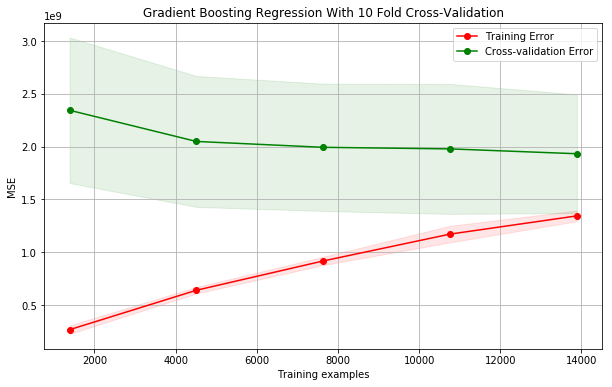

In [181]:
plot_learning_curve(best_model,'Gradient Boosting Regression With 10 Fold Cross-Validation', df_sel, salaries, cv=10)

#### Discussion

The model performs beter on the training set (accuracy = 67.51%) compared to the test set (accuracy = 49.52%) indicating that the model is overfitting to the training data.

The lower model accuracy can be attributed to the following reasons:
1. The number of features used to solve were drastically reduced from 533 to 100 based on the regularization. A higher number of features can be used to improve the model performance (accuracy on both training and test sets).
2. The LASSO in effect is a linear method. Therefore, there may be features which could otherwise be important for the prediction but were deemed trivial by the LASSO and hence removed.
3. The final train-test split was kept at 70-30 and the grid search was performed using 10 fold CV. With the result for each fold, only 63% of the data was used to build the model and tested on the remaining 7%. However if the train-test split was kept at 90-10, each fold would be trained on 81% of the data and tested on 9% which would be a better representation. On the other hand increasing the training size often results in overfitting of the model which is also not desirable.
4. The filling up of the missing values for many columns was done using a random sampling procedure based on frequency of non-Nan values. This can also be a potential cause of lower accuracy.

Following steps can be taken to improve the test accuracy:
1. Model fitting with higher number of features.
2. Regularization using a different model.